<a href="https://colab.research.google.com/github/Ahntea/pytorch_from_scratch/blob/main/age_model_fcn_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import os

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

filename = "/content/drive/MyDrive/thumbnail_list.txt"
import unicodedata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 한글 변환
name_list = []
with open(filename) as f:
    for line in f:
        name_list.append(unicodedata.normalize("NFC", line.strip()))

In [3]:
# thumbnail dataframe 생성
thumbnail = pd.DataFrame(name_list)
thumbnail["image"]= thumbnail[0].str.replace('_PMT.jpg', '.jpg')
thumbnail.rename(columns = {0:"filename"}, inplace = True)

In [4]:
# image 생성날짜 dataframe 로드 및 merge
imt = pd.read_csv("/content/drive/MyDrive/csv_image_table_1015.csv")

merged = pd.merge(thumbnail, imt, how="left", on = "image" )
merged['gen_date'] = pd.to_datetime(merged[['year','month','day']], format='%Y%m%d')
merged["birth_date"] = merged["image"].str.split('_', expand=True)[2]
merged["birth_date"] = merged["birth_date"].astype("datetime64[ns]")
merged["age"] = (merged["gen_date"] - merged["birth_date"]) / np.timedelta64(1, 'Y')
merged["age"].fillna(35, inplace=True)
merged["age"] = merged["age"].astype(int)
merged.loc[merged["age"]==119, "age"] = 19
merged["category"] = merged["image"].str.split('_', expand=True)[4]
d_ages = merged[['filename','age']].set_index('filename').T.to_dict('list')

In [5]:
# train 데이터 셋 생성
import os

dir_list = []
jpg_list = []
def search(dirname):
    filenames = os.listdir(dirname)
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        ext = os.path.splitext(full_filename)[-1]
        if ext != '.py': 
            dir_list.append(full_filename)

def search2(dirname):
    filenames = os.listdir(dirname)
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        ext = os.path.splitext(full_filename)[-1]
        if ext == '.jpg': 
            jpg_list.append(full_filename)
            
 # 폴더 경로
path = '/content/drive/MyDrive/thumbnail'
search(path)
for dl in dir_list:
  search2(dl)

In [6]:
import torch
# os.chdir(path) # 해당 폴더로 이동
# files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
x_train = np.empty((0,28800)) 
# x_train = np.empty((0,3, 96,100))
train_names = []
i = 0
for f in jpg_list[:20]:
  
  temp = np.array(Image.open(f))
  # print(f)
  if temp.shape == (96, 100, 3):
    train_names.append(unicodedata.normalize("NFC", f.split('/')[6]))
    x_train = np.append(x_train, temp.reshape(1,28800),axis=0)
    # x_train = np.append(x_train, temp.reshape(1,3, 96,100),axis=0)
x_train = x_train.astype(np.float32)
x_train = torch.tensor(x_train)

y_train = np.array([])
for n in train_names:
  # print(merged.loc[merged["filename"]==n, "age"])
  y_train = np.append(y_train, merged.loc[merged["filename"]==n, "age"].to_numpy())
y_train = y_train.astype(np.float32)
y_train = torch.tensor(y_train)

In [7]:
import torch.nn as nn
conv1 = nn.Conv2d(3, 32, 3, padding=1)
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
pool = nn.MaxPool2d(2)

In [17]:
print(x_train.shape)

torch.Size([200, 28800])


In [11]:
out1 = conv1(x_train)
print(out1.shape)

torch.Size([879, 32, 96, 100])


In [12]:
out2 = conv2(out1)
print(out2.shape)

torch.Size([879, 64, 96, 100])


In [13]:
out = pool(out2)
print(out.shape)

torch.Size([879, 64, 48, 50])


In [17]:
out = out.view(out.size(0), -1) 
print(out.shape)

torch.Size([879, 153600])


In [58]:
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape, y_train.shape)
print(y_train.min(), y_train.max())

tensor([[ 39.,  52., 120.,  ...,   7.,   6.,  12.],
        [ 23.,  32.,  87.,  ...,   6.,   7.,   9.],
        [ 47.,  59., 131.,  ...,  33.,  44.,  98.],
        ...,
        [ 97., 105., 124.,  ...,  13.,  14.,  16.],
        [ 96., 104., 123.,  ...,  16.,  16.,  24.],
        [114., 119., 138.,  ...,  64.,  75.,  93.]]) tensor([35., 35., 35.,  ..., 25., 25., 25.])
torch.Size([1891, 28800]) torch.Size([1891])
tensor(18.) tensor(73.)


In [59]:
# test 데이터 셋 생성
path = '/content/drive/MyDrive/test'
os.chdir(path) # 해당 폴더로 이동
files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
# x_valid = np.empty((0,28800))
x_valid = np.empty((0,3, 96,100,))
valid_names = []
print(merged["filename"].to_list())
for f in files:
  # check = False
  # if (unicodedata.normalize("NFC", f) in merged["filename"].to_list()):
  #   check =True

  temp = np.array(Image.open(f))
  if temp.shape == (96, 100, 3):
    valid_names.append(unicodedata.normalize("NFC", f))
    # x_valid = np.append(x_valid, temp.reshape(1,28800), axis=0)
    x_valid = np.append(x_valid, temp.reshape(1,3,96,100), axis=0)
x_valid = x_valid.astype(np.float32)
x_valid = torch.tensor(x_valid)

y_valid = np.array([])
for n in valid_names:
  y_valid = np.append(y_valid, merged.loc[merged["filename"]==n, "age"].to_numpy())
y_valid = y_valid.astype(np.float32)
y_valid = torch.tensor(y_valid)

['ASHLLLEY_F_1988-09-28_25701_보톡스_510993_PMT.jpg', 'ASHLLLEY_F_1988-09-28_25701_보톡스_510994_PMT.jpg', 'ASHLLLEY_F_1988-09-28_25701_보톡스_510995_PMT.jpg', 'chu츄_F_1983-06-07_17198_보톡스_308953_PMT.jpg', 'chu츄_F_1983-06-07_17198_보톡스_308954_PMT.jpg', 'chu츄_F_1983-06-07_17198_보톡스_308955_PMT.jpg', 'chu츄_F_1983-06-07_17198_보톡스_308956_PMT.jpg', 'chu츄_F_1983-06-07_17198_보톡스_308957_PMT.jpg', 'chu츄_F_1983-06-07_17198_보톡스_308958_PMT.jpg', '강산하_F_1900-03-28_24835_보톡스_486668_PMT.jpg', '강산하_F_1900-03-28_24835_보톡스_486669_PMT.jpg', '강산하_F_1900-03-28_24835_보톡스_486670_PMT.jpg', '강산하_F_1900-03-28_24835_보톡스_486671_PMT.jpg', '강산하_F_1900-03-28_24835_보톡스_486672_PMT.jpg', '김규리_F_1900-04-08_20676_보톡스_384660_PMT.jpg', '김규리_F_1900-04-08_20676_보톡스_384661_PMT.jpg', '김규리_F_1900-04-08_20676_보톡스_384662_PMT.jpg', '김규리_F_1900-04-08_20676_보톡스_384663_PMT.jpg', '김규리_F_1900-04-08_20676_보톡스_384664_PMT.jpg', '고채연_F_1900-08-25_29245_필러 - 전_618769_PMT.jpg', '고채연_F_1900-08-25_29245_필러 - 전_618770_PMT.jpg', '고채연_F_1900-08-25_29245_필러 

In [60]:
print(y_valid.shape, x_valid.shape)

torch.Size([86]) torch.Size([153, 28800])


In [7]:
# 모델 선언
import torch
from torch.utils.data import TensorDataset, DataLoader
from skimage import io, transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# x_train, y_train, x_valid, y_valid = map(
#     torch.tensor, (x_train/255, y_train, x_valid/255, y_valid)
# )
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# print(x_train.shape)
# n, c = x_train.shape
# print(x_train, y_train)
# print(x_train.shape)
# print(y_train.min(), y_train.max())

Using cuda device


In [ ]:
model = nn.Sequential(
    # nn.Conv2d(3, 32, 3, padding=1),
    # nn.Conv2d(32, 64, kernel_size=3, padding=1),
    # nn.MaxPool2d(2),
    # nn.Linear(153600, 7200),
    nn.Linear(28800, 7200),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(7200, 800), 
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(800, 16), 
    nn.ReLU(),
    nn.Linear(16, 1) 
)
print(list(model.parameters()))
import math

# weights = torch.randn(28800, 1) / math.sqrt(28800)
# weights.requires_grad_()
# bias = torch.zeros(1, requires_grad=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5) 
loss_fn = nn.MSELoss()
losses = []

In [ ]:
nb_epochs = 5000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.
    # print(prediction.shape, y_train.shape)
    # cost 계산
    loss = loss_fn(prediction, y_train.reshape(20,1)) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    # optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    loss.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, loss.item()
      ))
    
    losses.append(loss.item())

Epoch    0/5000 Cost: 855.341980
Epoch  100/5000 Cost: 712.767944
Epoch  200/5000 Cost: 813.544800
Epoch  300/5000 Cost: 907.527222
Epoch  400/5000 Cost: 445.028717


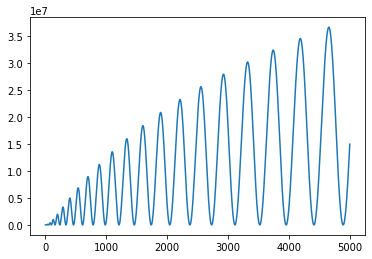

In [84]:
plt.plot(losses)

In [ ]:
pred_y = []

In [ ]:
for i in range(len(x_valid)):
  pred_y.append(model(x_valid[i]).detach().item())

In [ ]:
print(len(y_valid), len(pred_y))

86 153


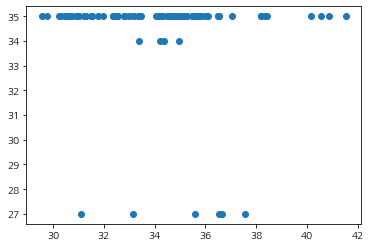

In [ ]:
plt.scatter(pred_y[:86], y_valid)

In [ ]:
class LinearRegressionModel(nn.Module): # torch.nn.Module을 상속받는 파이썬 클래스
    def __init__(self): #
        super().__init__()
        self.linear = nn.Linear(28800, 1) # 단순 선형 회귀이므로 input_dim=1, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [ ]:
model = LinearRegressionModel()